# OCR Invoice recognition
- https://dottxt-ai.github.io/outlines/latest/cookbook/receipt-digitization/

- This executed in colab

In [1]:
!pip install outlines torch==2.5.1 accelerate pillow rich  -q #

In [2]:
!pip install git+https://github.com/huggingface/transformers@21fac7abba2a37fae86106f87fcf9974fd1e3830 accelerate -q
#NOTE: Current latest version of transformers have a bug when loading Qwen2-VL config, so you need to install a specific version of transformers as above.

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install datasets fsspec==2024.10.0 -q

In [3]:
!pip show transformers

Name: transformers
Version: 4.45.0.dev0
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


## Import libraries
- Load all the necessary libraries:

In [4]:
# LLM stuff
import outlines
import torch
from pydantic import BaseModel, Field
from typing import Literal, Optional, List
from transformers import AutoProcessor

# Image stuff
from PIL import Image
import requests

# Rich for pretty printing
from rich import print

## Choose a model
- This example has been tested with mistral-community/pixtral-12b (HF link) and Qwen/Qwen2-VL-7B-Instruct (HF link).
- We recommend Qwen-2-VL as we have found it to be more accurate than Pixtral.
- If you want to use Qwen-2-VL, you can do the following:

### If you want to use Qwen2-VL-7B, you can do the following:

In [33]:
# To use Qwen-2-VL:
from transformers import Qwen2VLForConditionalGeneration
model_name =   "Qwen/Qwen2-VL-7B-Instruct" # "Qwen/Qwen2-VL-7B-Instruct"  #Qwen/Qwen2.5-7B-Instruct  "Qwen2-VL-72B" #
model_class = Qwen2VLForConditionalGeneration

### If you want to use Pixtral, you can do the following:

In [17]:
# # To use Pixtral:
# from transformers import LlavaForConditionalGeneration
# model_name="mistral-community/pixtral-12b"
# model_class=LlavaForConditionalGeneration

## Load the model
Load the model into memory from hugging face:

In [34]:
model = outlines.models.transformers_vision(
    model_name,
    model_class=model_class,
    model_kwargs={
        "device_map": "auto",
        "torch_dtype": torch.bfloat16,
    },
    processor_kwargs={
        "device": "cuda", # set to "cpu" if you don't have a GPU
    },
)

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

You are using a model of type qwen2 to instantiate a model of type qwen2_vl. This is not supported for all configurations of models and can yield errors.


model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of Qwen2VLForConditionalGeneration were not initialized from the model checkpoint at Qwen/Qwen2.5-7B-Instruct and are newly initialized: ['visual.blocks.0.attn.proj.bias', 'visual.blocks.0.attn.proj.weight', 'visual.blocks.0.attn.qkv.bias', 'visual.blocks.0.attn.qkv.weight', 'visual.blocks.0.mlp.fc1.bias', 'visual.blocks.0.mlp.fc1.weight', 'visual.blocks.0.mlp.fc2.bias', 'visual.blocks.0.mlp.fc2.weight', 'visual.blocks.0.norm1.bias', 'visual.blocks.0.norm1.weight', 'visual.blocks.0.norm2.bias', 'visual.blocks.0.norm2.weight', 'visual.blocks.1.attn.proj.bias', 'visual.blocks.1.attn.proj.weight', 'visual.blocks.1.attn.qkv.bias', 'visual.blocks.1.attn.qkv.weight', 'visual.blocks.1.mlp.fc1.bias', 'visual.blocks.1.mlp.fc1.weight', 'visual.blocks.1.mlp.fc2.bias', 'visual.blocks.1.mlp.fc2.weight', 'visual.blocks.1.norm1.bias', 'visual.blocks.1.norm1.weight', 'visual.blocks.1.norm2.bias', 'visual.blocks.1.norm2.weight', 'visual.blocks.10.attn.proj.bias', 'visual.blocks.10.attn.pro

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

## Image processing
Images can be quite large. In GPU-poor environments, you may need to resize the image to a smaller size.

Here's a helper function to do that:

In [35]:
def load_and_resize_image(image_path, max_size=1024):
    """
    Load and resize an image while maintaining aspect ratio

    Args:
        image_path: Path to the image file
        max_size: Maximum dimension (width or height) of the output image

    Returns:
        PIL Image: Resized image
    """
    image = Image.open(image_path)

    # Get current dimensions
    width, height = image.size

    # Calculate scaling factor
    scale = min(max_size / width, max_size / height)

    # Only resize if image is larger than max_size
    if scale < 1:
        new_width = int(width * scale)
        new_height = int(height * scale)
        image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)

    return image

> You can change the resolution of the image by changing the max_size argument. Small max sizes will make the image more blurry, but processing will be faster and require less memory.

## Load an image
- Load an image and resize it. We've provided a sample image of a Trader Joe's receipt, but you can use any image you'd like.

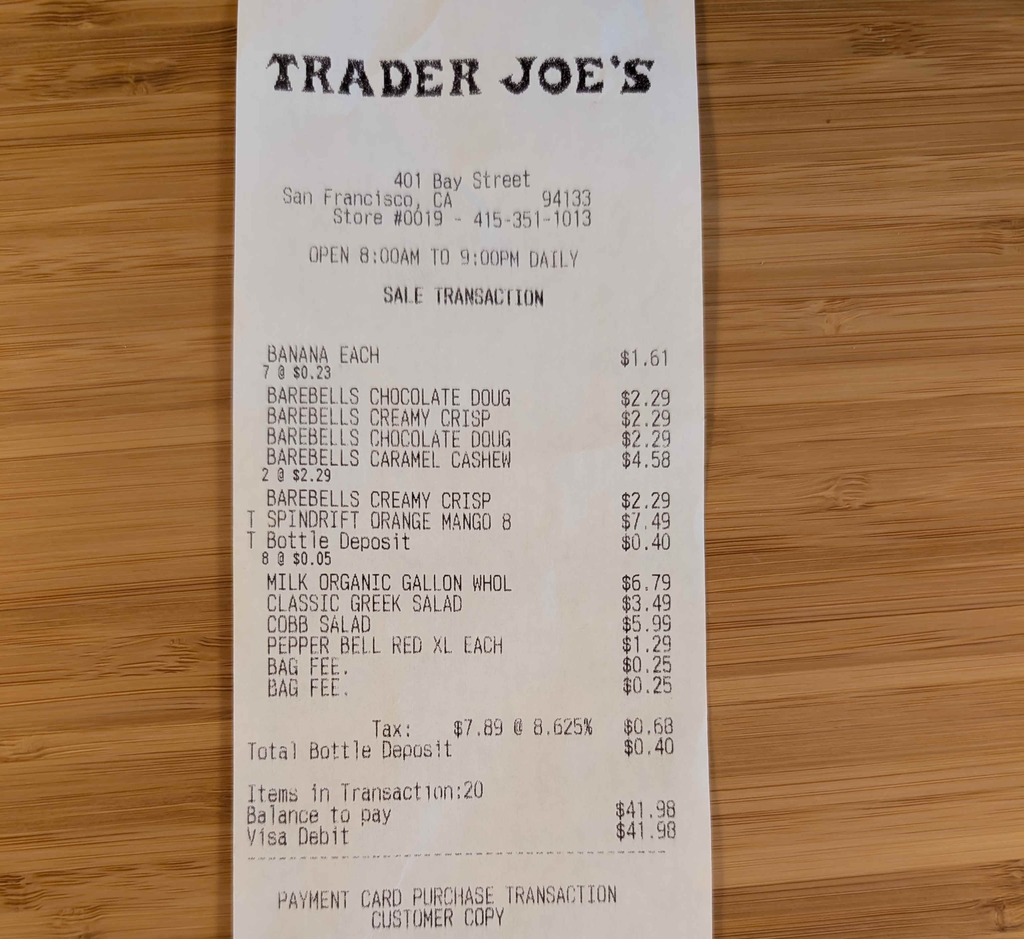

In [36]:
# Path to the image
image_path = "https://raw.githubusercontent.com/dottxt-ai/outlines/refs/heads/main/docs/cookbook/images/trader-joes-receipt.jpg"

# Download the image
response = requests.get(image_path)
with open("receipt.png", "wb") as f:
    f.write(response.content)

# Load + resize the image
image = load_and_resize_image("receipt.png")
image

## Define the output structure
- We'll define a Pydantic model to describe the data we want to extract from the image.

- In our case, we want to extract the following information:

    - The store name
    - The store address
    - The store number
- A list of items, including the name, quantity, price per unit, and total price
    - The tax
    - The total
    - The date
    - he payment method
- Most fields are optional, as not all receipts contain all information.

In [37]:
class Item(BaseModel):
    name: str
    quantity: Optional[int]
    price_per_unit: Optional[float]
    total_price: Optional[float]

class ReceiptSummary(BaseModel):
    store_name: str
    store_address: str
    store_number: Optional[int]
    items: List[Item]
    tax: Optional[float]
    total: Optional[float]
    # Date is in the format YYYY-MM-DD. We can apply a regex pattern to ensure it's formatted correctly.
    date: Optional[str] = Field(pattern=r'\d{4}-\d{2}-\d{2}', description="Date in the format YYYY-MM-DD")
    payment_method: Literal["cash", "credit", "debit", "check", "other"]

## Prepare the prompt
- We'll use the AutoProcessor to convert the image and the text prompt into a format that the model can understand. Practically, this is the code that adds user, system, assistant, and image tokens to the prompt.

In [38]:
# Set up the content you want to send to the model
messages = [
    {
        "role": "user",
        "content": [
            {
                # The image is provided as a PIL Image object
                "type": "image",
                "image": image,
            },
            {
                "type": "text",
                "text": f"""You are an expert at extracting information from receipts.
                Please extract the information from the receipt. Be as detailed as possible --
                missing or misreporting information is a crime.

                Return the information in the following JSON schema:
                {ReceiptSummary.model_json_schema()}
            """},
        ],
    }
]



## Convert the messages to the final prompt

In [39]:
# Convert the messages to the final prompt
processor = AutoProcessor.from_pretrained(model_name)

prompt = processor.apply_chat_template(
              messages,
              tokenize=False,
              add_generation_prompt=True
          )

> If you are curious, the final prompt that is sent to the model looks (roughly) like this:

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>
You are an expert at extracting information from receipts.
Please extract the information from the receipt. Be as detailed as
possible -- missing or misreporting information is a crime.

Return the information in the following JSON schema:

<JSON SCHEMA OMITTED>
<|im_end|>
<|im_start|>assistant

## Run the model

In [ ]:
# Prepare a function to process receipts
receipt_summary_generator = outlines.generate.json(
        model,  # Vision model
        ReceiptSummary, # Structured O/P Fprmat

        # Choose different sampler method:
        # Greedy sampling is a good idea for numeric
        # data extraction -- no randomness.
        sampler=outlines.samplers.greedy()
)

In [ ]:
# Generate the receipt summary bty passing prompt +image
result = receipt_summary_generator(prompt, [image])
print(result)

## Output
The output should look like this:

```
ReceiptSummary(
    store_name="Trader Joe's",
    store_address='401 Bay Street, San Francisco, CA 94133',
    store_number=0,
    items=[
        Item(name='BANANA EACH', quantity=7, price_per_unit=0.23, total_price=1.61),
        Item(name='BAREBELLS CHOCOLATE DOUG', quantity=1, price_per_unit=2.29, total_price=2.29),
        Item(name='BAREBELLS CREAMY CRISP', quantity=1, price_per_unit=2.29, total_price=2.29),
        Item(name='BAREBELLS CHOCOLATE DOUG', quantity=1, price_per_unit=2.29, total_price=2.29),
        Item(name='BAREBELLS CARAMEL CASHEW', quantity=2, price_per_unit=2.29, total_price=4.58),
        Item(name='BAREBELLS CREAMY CRISP', quantity=1, price_per_unit=2.29, total_price=2.29),
        Item(name='SPINDRIFT ORANGE MANGO 8', quantity=1, price_per_unit=7.49, total_price=7.49),
        Item(name='Bottle Deposit', quantity=8, price_per_unit=0.05, total_price=0.4),
        Item(name='MILK ORGANIC GALLON WHOL', quantity=1, price_per_unit=6.79, total_price=6.79),
        Item(name='CLASSIC GREEK SALAD', quantity=1, price_per_unit=3.49, total_price=3.49),
        Item(name='COBB SALAD', quantity=1, price_per_unit=5.99, total_price=5.99),
        Item(name='PEPPER BELL RED XL EACH', quantity=1, price_per_unit=1.29, total_price=1.29),
        Item(name='BAG FEE.', quantity=1, price_per_unit=0.25, total_price=0.25),
        Item(name='BAG FEE.', quantity=1, price_per_unit=0.25, total_price=0.25)
    ],
    tax=0.68,
    total=41.98,
    date='2023-11-04',
    payment_method='debit',

)
```

## Bonus: roasting the user for their receipt
You can roast the user for their receipt by adding a roast field to the end of the ReceiptSummary model.

In [29]:
class ReceiptSummary(BaseModel):
    ...
    roast: str

> which gives you a result like

ReceiptSummary(
    ...
    roast="You must be a fan of Trader Joe's because you bought enough
    items to fill a small grocery bag and still had to pay for a bag fee.
    Maybe you should start using reusable bags to save some money and the
    environment."
)

# More Details refer
- https://github.com/QwenLM/Qwen2-VL

# Ollama(local) hosted model invoke using Opean AI framework 
- After installing ollama, you can initiate the ollama service with the following command:

```
ollama serve

```
#### You need to keep this service running whenever you are using ollama

> To pull a model checkpoint and run the model, use the ollama run command. You can specify a model size by adding a suffix to qwen2.5, such as :0.5b, :1.5b, :7b, or :72b:

In [ ]:
ollama run qwen2.5:7b
# To exit, type "/bye" and press ENTER

> You can also access the ollama service via its OpenAI-compatible API. Please note that you need to (1) keep ollama serve running while using the API, and (2) execute ollama run qwen2.5:7b before utilizing this API to ensure that the model checkpoint is prepared.

In [ ]:
from openai import OpenAI
client = OpenAI(
    base_url='http://localhost:11434/v1/',  #Ollama endpoint
    api_key='ollama',  # required but ignored
)
chat_completion = client.chat.completions.create(
    messages=[
        {
            'role': 'user',
            'content': 'Say this is a test',
        }
    ],
    model='qwen2.5:7b',
)

### vLLM (This same like ollama)
- We advise you to use the latest version of vLLM to build **OpenAI-compatible API service**, including **tool use support**. Start the server with a chat model, e.g. Qwen2.5-7B-Instruct:

In [ ]:
from openai import OpenAI
# Set OpenAI's API key and API base to use vLLM's API server.
openai_api_key = "EMPTY"
openai_api_base = "http://localhost:8000/v1"

client = OpenAI(
    api_key=openai_api_key,
    base_url=openai_api_base,
)

chat_response = client.chat.completions.create(
    model="Qwen2.5-7B-Instruct",
    messages=[
        {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
        {"role": "user", "content": "Tell me something about large language models."},
    ],
    temperature=0.7,
    top_p=0.8,
    max_tokens=512,
    extra_body={
        "repetition_penalty": 1.05,
    },
)
print("Chat response:", chat_response)